## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******


## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
transcriptomics = en.get_transcriptomics()
clinical = en.get_clinical()

Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...


In [3]:
#Append Genomics_subtype and MSI_status to clinical table
df= en.get_derived_molecular()
clinical['MSI_status'] = df['MSI_status']
clinical['Genomics_subtype'] = df['Genomics_subtype']

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())
annotations = annotations.drop(['Patient_ID', 
                                'Treatment_naive', 
                                'Tumor_purity', 
                                'Gender', 
                                'Tumor_Site_Other'], axis=1)

## Step 2a: Binarize column values

In [5]:
tumor_map = {'Tumor':'Normal_Tumor', 
             'Adjacent_normal':'Other_tumor', 
             'Enriched_normal':'Other_tumor', 
             'Myometrium_normal':'Other_tumor'}

annotations['Proteomics_Tumor_Normal'] = bf.binarizeCategorical(clinical, 
                                                                'Proteomics_Tumor_Normal', 
                                                                tumor_map)

In [6]:
country_map = {'United States':'US', 
               'Ukraine':'Other', 
               'Other_specify':'Other', 
               'Poland':'Other'}

annotations['Country'] = bf.binarizeCategorical(clinical, 
                                                'Country', 
                                                country_map)

In [7]:
annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 
                                      'Healthy', 'Unhealthy')

annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       60.0, 'Old', 'Young')

In [8]:
FIGO_map = {'FIGO grade 1':'Low_grade', 
            'FIGO grade 2':'High_grade', 
            'FIGO grade 3':'High_grade'}

annotations['Histologic_Grade_FIGO'] = bf.binarizeCategorical(clinical, 
                                                              'Histologic_Grade_FIGO', 
                                                              FIGO_map)

In [9]:
Myo_map = {'under 50 %':'under_50%', 
           '50 % or more': '50%_or_more', 
           'Not identified': 'under_50%'}

annotations['Myometrial_invasion_Specify'] = bf.binarizeCategorical(clinical, 
                                                                    'Myometrial_invasion_Specify', 
                                                                    Myo_map)

In [10]:
path_tumor_map = {'pT1a (FIGO IA)':'Not_FIGO_III', 
            'pT1b (FIGO IB)':'Not_FIGO_III', 
            'pT2 (FIGO II)':'Not_FIGO_III', 
            'pT1 (FIGO I)':'Not_FIGO_III', 
            'pT3a (FIGO IIIA)':'FIGO_III', 
            'pT3b (FIGO IIIB)':'FIGO_III'}

annotations['Path_Stage_Primary_Tumor-pT'] = bf.binarizeCategorical(clinical, 
                                                                    'Path_Stage_Primary_Tumor-pT', 
                                                                    path_tumor_map)

In [11]:
path_lymph_map = {'pN0':'Not_FIGO_III', 
                  'pNX':'Not_FIGO_III', 
                  'pN1 (FIGO IIIC1)':'FIGO_III', 
                  'pN2 (FIGO IIIC2)':'FIGO_III'}

annotations['Path_Stage_Reg_Lymph_Nodes-pN'] = bf.binarizeCategorical(clinical, 
                                                                      'Path_Stage_Reg_Lymph_Nodes-pN', 
                                                                      path_lymph_map)

In [12]:
clin_stage_map = {'cM0':'cM0_or_cM1', 
                  'cM1':'cM0_or_cM1', 
                  'Staging Incomplete':'Staging_Incomplete'}

annotations['Clin_Stage_Dist_Mets-cM'] = bf.binarizeCategorical(clinical, 
                                                                'Clin_Stage_Dist_Mets-cM', 
                                                                clin_stage_map)

In [13]:
path_stage_map = {'Staging Incomplete': 'No_distant_metastasis', 
                  'No pathologic evidence of distant metastasis':'No_distant_metastasis', 
                  'pM1':'Distant_Metastasis'}

annotations['Path_Stage_Dist_Mets-pM'] = bf.binarizeCategorical(clinical, 
                                                                'Path_Stage_Dist_Mets-pM', 
                                                                path_stage_map)

In [14]:
tumor_stage_map = {'Stage I':'Stage_I_or_II', 
                   'Stage II':'Stage_I_or_II', 
                   'Stage III':'Stage_III_or_IV', 
                   'Stage IV':'Stage_III_or_IV'}

annotations['tumor_Stage-Pathological'] = bf.binarizeCategorical(clinical, 
                                                               'tumor_Stage-Pathological', 
                                                               tumor_stage_map)

In [15]:
FIGO_stage_map = {'IA':'I_or_II', 
                  'IB':'I_or_II', 
                  'II':'I_or_II', 
                  'IIIA':'III_or_IV', 
                  'IIIC1':'III_or_IV', 
                  'IVB':'III_or_IV', 
                  'IIIC2':'III_or_IV', 
                  'IIIB':'III_or_IV'}

annotations['FIGO_stage'] = bf.binarizeCategorical(clinical, 
                                                   'FIGO_stage', 
                                                   FIGO_stage_map)

In [16]:
diabetes_map = {'No':'No', 
                'Yes':'Yes', 
                'Unknown':'No'}

annotations['Diabetes'] = bf.binarizeCategorical(clinical, 
                                                 'Diabetes', 
                                                 diabetes_map)

In [17]:
race_map = {'White':'White', 
            'Black or African American':'Not_White', 
            'Asian':'Not_White', 
            'Not Reported':'Not_White'}

annotations['Race'] = bf.binarizeCategorical(clinical, 
                                             'Race', 
                                             race_map)

In [18]:
ethnicity_map = {'Not-Hispanic or Latino':'Not_Hispanic', 
                 'Not reported':'Not_Hispanic', 
                 'Hispanic or Latino':'Hispanic'}

annotations['Ethnicity'] = bf.binarizeCategorical(clinical, 
                                                  'Ethnicity', 
                                                  ethnicity_map)

In [19]:
tumor_site_map = {'Other, specify':'Not_Anterior', 
                  'Anterior endometrium':'Anterior', 
                  'Posterior endometrium':'Not_Anterior'}

annotations['Tumor_Site'] = bf.binarizeCategorical(clinical, 
                                                   'Tumor_Site', 
                                                   tumor_site_map)

In [20]:
annotations['Tumor_Size_cm'] = bf.binarizeCutOff(clinical, 
                                                'Tumor_Size_cm', 4.0, 
                                                'Large_tumor', 
                                                'Small_tumor')

In [21]:
num_pregnancies_map = {2:'Less_than_3', 
                       1:'Less_than_3', 
                       'None':'Less_than_3', 
                       None:'Less_than_3', 
                       3:'3_or_more', 
                       '4 or more':'3_or_more'}

annotations['Num_full_term_pregnancies'] = bf.binarizeCategorical(clinical, 
                                                                  'Num_full_term_pregnancies', 
                                                                  num_pregnancies_map)

In [22]:
genomics_map = {'MSI-H':'MSI-H', 
                'CNV_low':'Other_subtype', 
                'CNV_high':'Other_subtype', 
                'POLE':'Other_subtype'}

annotations['Genomics_subtype'] = bf.binarizeCategorical(clinical, 
                                                         'Genomics_subtype', 
                                                         genomics_map)

## Step 3: Perform outliers analysis

In [23]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_trans = blsh.make_outliers_table(transcriptomics, iqrs=1.5, 
                                          up_or_down='up', 
                                          aggregate=False, 
                                          frac_table=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [35]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

results_trans = blsh.compare_groups_outliers(outliers_trans, 
                                             annotations)

No rows had outliers in at least 0.3 of Proteomics_Tumor_Normal Normal_Tumor samples
Testing 14 rows for enrichment in Proteomics_Tumor_Normal Other_tumor samples
No rows had outliers in at least 0.3 of Country Other samples
No rows had outliers in at least 0.3 of Country US samples
Testing 2 rows for enrichment in Histologic_Grade_FIGO High_grade samples
Testing 1 rows for enrichment in Histologic_Grade_FIGO Low_grade samples
No rows had outliers in at least 0.3 of Myometrial_invasion_Specify under_50% samples
Testing 7 rows for enrichment in Myometrial_invasion_Specify 50%_or_more samples
No rows had outliers in at least 0.3 of Histologic_type Endometrioid samples
Testing 626 rows for enrichment in Histologic_type Serous samples
No rows had outliers in at least 0.3 of Path_Stage_Primary_Tumor-pT Not_FIGO_III samples
Testing 241 rows for enrichment in Path_Stage_Primary_Tumor-pT FIGO_III samples
No rows had outliers in at least 0.3 of Path_Stage_Reg_Lymph_Nodes-pN Not_FIGO_III samples

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [36]:
results_prot = results_prot.dropna(axis=0, how='all')
results_trans = results_trans.dropna(axis=0, how='all')

In [37]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) >= 5:
        sig_cols.append(sig_col)
    else:
        results_prot = results_prot.drop(col, axis=1)

TESTING FOR PROTEOMICS:
14 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor

2 significant protein enrichments in Myometrial_invasion_Specify_50%_or_more

412 significant protein enrichments in Histologic_type_Serous

1 significant protein enrichment in Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III:

8 significant protein enrichments in LVSI_1.0

2 significant protein enrichments in Age_Young

3 significant protein enrichments in Tumor_Site_Anterior

2 significant protein enrichments in Tumor_Focality_Multifocal

3 significant protein enrichments in MSI_status_MSI-H

3 significant protein enrichments in Genomics_subtype_MSI-H



## Step 5: Visualize these enrichments

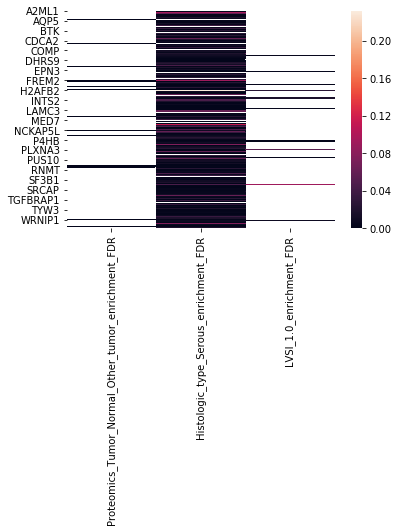

In [38]:
sns.heatmap(results_prot)
plt.show()

TESTING FOR TRANSCRIPTOMICS:
1351 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor

1 significant protein enrichment in Histologic_Grade_FIGO_High_grade:

955 significant protein enrichments in Histologic_type_Serous

8 significant protein enrichments in MSI_status_MSI-H

8 significant protein enrichments in Genomics_subtype_MSI-H



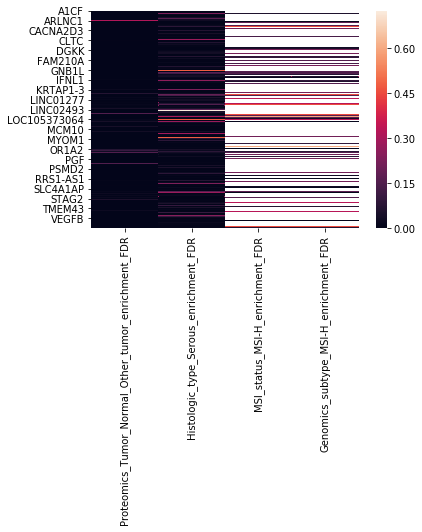

In [39]:
#genes vs samples visualization. See Endometrial paper for example
#DGIDB based in R and probably has API. Try wrapping this into Python 
#and make a function to make it all Python. Or even include the table
#in the package.

#Look for significant enrichments
print("TESTING FOR TRANSCRIPTOMICS:")
sig_cols = []
for col in results_trans.columns:
    sig_col = bf.significantEnrichments(results_trans, col, 0.01)
    if sig_col is not None and len(sig_col) > 5:
        sig_cols.append(sig_col)
    else:
        results_trans = results_trans.drop(col, axis=1)

#Visualization
sns.heatmap(results_trans)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [30]:
'''
#Look for background set of genes. Can we specify?
#enrichr vs gsea
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human',
                            outdir='test/enrichr_kegg',
                            cutoff=0.5)
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)
'''

            Gene_set                                               Term  \
0    KEGG_2019_Human                  Ribosome biogenesis in eukaryotes   
1    KEGG_2019_Human                                        Spliceosome   
2    KEGG_2019_Human                                      RNA transport   
3    KEGG_2019_Human                          mRNA surveillance pathway   
4    KEGG_2019_Human                                     RNA polymerase   
5    KEGG_2019_Human                           Hepatocellular carcinoma   
6    KEGG_2019_Human                     Ubiquitin mediated proteolysis   
7    KEGG_2019_Human                                        Influenza A   
8    KEGG_2019_Human                      Cytosolic DNA-sensing pathway   
9    KEGG_2019_Human                        Basal transcription factors   
10   KEGG_2019_Human                                            Malaria   
11   KEGG_2019_Human                  Thyroid hormone signaling pathway   
12   KEGG_2019_Human     

[192 rows x 10 columns]


ConnectionError: HTTPConnectionPool(host='amp.pharm.mssm.edu', port=80): Max retries exceeded with url: /Enrichr/datasetStatistics (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000167474C0320>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond',))